# LIBS Analysis

In [2]:
# auto reload external packages
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
# import dependencies
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from plotly.offline import iplot, init_notebook_mode
import plotly.tools as tls
import plotly.graph_objs as go



init_notebook_mode(connected=True)

In [4]:
# raw_reading: single reading (corrupted or not, it is unknown)
# reading: subsampled or averaged multiple raw_readings - probably more noise free

# {BASEPATH}/{sample_path}/{raw_readings}.csv

# sample_path : one path of sample of soils (adana, samsun, etc.) - ex:{BASEPATH}/{labno}
# raw_reading_path : one path reading of one sample of soils (adana, samsun, etc.) - ex:{BASEPATH}/{labno}/{unix_rtime}.csv

BASEPATH = "samples"
LOCATION = "adana" # adana, samsun, nigde, yozgat

In [80]:
# create and save .png file for all readings per sample
def subplot25(sample_readings_paths):
    fig, axes = plt.subplots(2, 5, sharex=True, sharey=True, figsize=(30,10))
    for ix, sample_path in enumerate(sample_readings_paths):
        df = pd.read_csv(sample_path)
        ax = axes[ix//5,ix%5]
        ax.plot(df['wavelengths'], df['intensities'], )
        ax.set_title(sample_path.name)
    fig.suptitle(sample_path.parent.name)
    image_save_path = sample_path.parent
    plt.savefig(image_save_path / 'readings.png')

In [65]:
samples_paths = list(Path(BASEPATH).glob('*'))
for sample_path in samples_paths:
    raw_reading_paths = Path(sample_path).glob('*.csv') # filter csv files
    subplot25(raw_reading_paths)

[WindowsPath('samples/12631/1561815664.4538357.csv'),
 WindowsPath('samples/12631/1561815666.776177.csv'),
 WindowsPath('samples/12631/1561815669.5037115.csv'),
 WindowsPath('samples/12631/1561815672.029567.csv'),
 WindowsPath('samples/12631/1561815674.9583936.csv'),
 WindowsPath('samples/12631/1561815677.7870643.csv'),
 WindowsPath('samples/12631/1561815680.5122619.csv'),
 WindowsPath('samples/12631/1561815682.8366802.csv'),
 WindowsPath('samples/12631/1561815685.7612813.csv'),
 WindowsPath('samples/12631/1561815688.3846374.csv')]

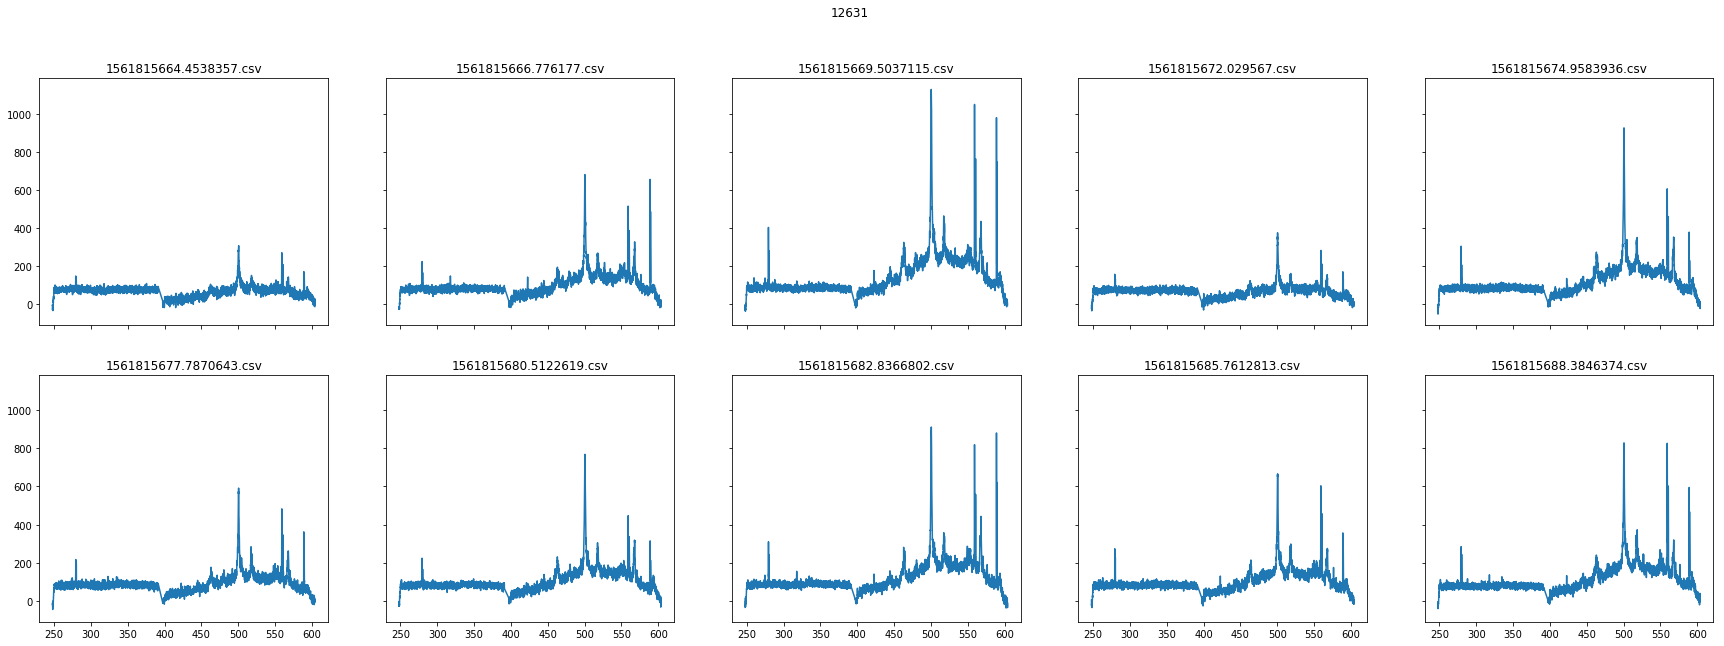

In [76]:
subplot25(raw_reading_paths)

In [20]:
from functools import partial
from scipy import signal

class Sample:
    def __init__(self, path):
        self.raw_readings = [pd.read_csv(os.path.join(path, reading_name)) 
                             for reading_name in os.listdir(path) if os.path.splitext(reading_name)[-1] == '.csv']
        
        # average samples
        self.reading = self.dataframes_average(self.raw_readings)
        # round sample
        self.reading = self.reading.round(3)
        self.plot = partial(self.subplot, [self.reading], 1, 1)
        
        self.reading = self.find_peaks(self.reading)
        self.path = path
        self.labno = int(path.split('\\')[-1])
    
    @staticmethod
    def find_peaks(reading, inplace=False):
        if not inplace:
            reading = reading.copy()
        
        peak_interval = 1.
        wavelengths = reading['wavelengths'].values
        intensities = reading['intensities'].values
        
        wavelengths_range = wavelengths.max() - wavelengths.min()
        sampling_interval = wavelengths_range / wavelengths.shape[0]

        peak_ixs = signal.argrelmax(intensities,
                                    order=int(peak_interval / sampling_interval))[0]
        
        reading['is_peak'] = False
        reading.loc[peak_ixs, 'is_peak'] = True
        return reading
    
    @staticmethod
    def get_reading_cond(intensities_above=200, is_peak=True):
        return s.reading.loc[(s.reading['intensities'] > intensities_above) & (s.reading['is_peak']==is_peak)]
        
        
    @staticmethod
    def subplot(readings, row, col):
        fig, axes = plt.subplots(row, col, sharex=True, sharey=True, squeeze=False)
        for ix, reading in enumerate(readings):
            axes[ix//col,ix%col if col!=1 else 0].plot(reading['wavelengths'], reading['intensities'])

    @staticmethod
    def plotly_plot(s):
        peak_df = s.reading.loc[s.reading['is_peak'] == True, :]
        trace_reading = go.Scatter(x=s.reading['wavelengths'], y=s.reading['intensities'], name='reading')
        trace_peak = go.Scatter(x=peak_df['wavelengths'], y=peak_df['intensities'], mode='markers', name='peaks')
        layout = go.Layout(
            xaxis=dict(
                range=[200, 700]
            ),
            yaxis=dict(
                range=[0, 2000]
            )
        )
        fig = go.Figure(data=[trace_reading, trace_peak], layout=layout)
        return fig
    
    
#     @staticmethod
#     def dataframes_round(dataframes):
#         r_dataframes = []
#         for df in dataframes:
#             r_dataframes += [df.round(2)]
#         return r_dataframes
    
    @staticmethod
    def dataframes_average(dataframes):
        avg_df = dataframes[0].copy()
        for df in dataframes[1:]:
            avg_df += df
        return avg_df / dataframes.__len__()
    
    def get_peak(self, nm):
        return self.reading.loc[self.reading['wavelengths'] == nm, 'intensities'].values[0]
        


In [53]:
# choose nm
s.reading.loc[(s.reading['intensities'] > 200) & (s.reading['is_peak']==True)]
N_nm = 589.024 # above equation's last entry

# N için 500nm ekle.

# Azotu tekrarlananlar

In [27]:
df = pd.read_excel("Azotu tekrarlananlar.xlsx")

In [28]:
# get only valid samples
df = df.loc[df['Valid']==1, :] 

In [29]:
# get adana only
df_adana = df.loc[df['Loc']=='Adana', :]

In [30]:
df_adana = df_adana.dropna(axis=1).sort_values(by=['Lab no']).reset_index(drop=True)


In [31]:
df_adana

,Lab no,Loc,SampleNo,Valid,%Azot
0,12636,Adana,41,1,0.84
1,12637,Adana,42,1,0.22
2,12638,Adana,35,1,0.17
3,12639,Adana,49,1,0.39
4,12642,Adana,28,1,0.22
5,12643,Adana,37,1,0.84
6,12645,Adana,30,1,0.22
7,12648,Adana,43,1,0.45
8,12649,Adana,26,1,0.34
9,13039,Adana,32,1,0.17


In [43]:
N_nms = [500.540,
        [589.024, 589.116],
        279.482,
        334.762,
        421.624,
        [443.506, 443.613]]

In [42]:
s = Sample(path=samples_paths[0])
s.reading.loc[(s.reading['is_peak'] == True) & (s.reading['wavelengths'] > 490)]

,wavelengths,intensities,is_peak
2922,490.715,149.954,True
2958,494.410,163.371,True
3018,500.540,705.378,True
3057,504.505,249.409,True
3110,509.869,159.540,True
3130,511.886,157.292,True
3185,517.411,287.641,True
3282,527.080,184.990,True
3315,530.347,151.767,True
3341,532.912,168.109,True


In [47]:
samples = list()
for path in samples_paths:
    samples += [Sample(path=path)]

def create_nm_columns(df):
    for i, N_nm in enumerate(N_nms):
        peak_str = ''
        if isinstance(N_nm, (list,)):
            peak_str = '-'.join([f'N{i}@{eachnm}' for eachnm in N_nm])
        else:
            peak_str += f'N{i}@{N_nm}'
        
        df[peak_str] = np.nan
    return df

def insert_peak_values(df):
    for sample in samples:
        for i, N_nm in enumerate(N_nms):
            peak_str = ''
            peak_value = 0.
            if isinstance(N_nm, (list,)):
                peak_str = '-'.join([f'N{i}@{eachnm}' for eachnm in N_nm])
                peak_value = sum([sample.get_peak(eachnm) for eachnm in N_nm])
            else:
                peak_str += f'N{i}@{N_nm}'
#                 print(N_nm, sample.labno)
                peak_value = sample.get_peak(N_nm)

            df.loc[df['Lab no']==sample.labno, peak_str] = peak_value
    return df
        
df_adana = create_nm_columns(df_adana.copy())
df_adana = insert_peak_values(df_adana.copy())
df_adana   

,Lab no,Loc,SampleNo,Valid,%Azot,N0@589.024-N0@589.116,N1@279.482,N2@334.762,N3@421.624,N4@443.506-N4@443.613,N0@500.54,N1@589.024-N1@589.116,N2@279.482,N3@334.762,N4@421.624,N5@443.506-N5@443.613
0,12636,Adana,41,1,0.84,265.760,137.788,79.926,27.372,172.213,301.507,265.760,137.788,79.926,27.372,172.213
1,12637,Adana,42,1,0.22,407.464,186.979,90.965,40.937,159.081,505.421,407.464,186.979,90.965,40.937,159.081
2,12638,Adana,35,1,0.17,450.602,205.041,88.110,43.352,179.935,554.804,450.602,205.041,88.110,43.352,179.935
3,12639,Adana,49,1,0.39,246.286,124.388,77.071,13.921,85.405,154.259,246.286,124.388,77.071,13.921,85.405
4,12642,Adana,28,1,0.22,416.137,159.776,82.484,31.039,169.484,396.895,416.137,159.776,82.484,31.039,169.484
5,12643,Adana,37,1,0.84,346.302,165.129,85.761,50.893,200.965,601.435,346.302,165.129,85.761,50.893,200.965
6,12645,Adana,30,1,0.22,267.190,136.206,78.864,22.262,185.258,308.965,267.190,136.206,78.864,22.262,185.258
7,12648,Adana,43,1,0.45,657.258,179.545,91.903,37.550,157.949,482.438,657.258,179.545,91.903,37.550,157.949
8,12649,Adana,26,1,0.34,264.773,128.499,81.075,26.458,183.079,376.207,264.773,128.499,81.075,26.458,183.079
9,13039,Adana,32,1,0.17,389.858,155.150,80.127,26.045,151.334,347.454,389.858,155.150,80.127,26.045,151.334


In [48]:
plot_df = df_adana.sort_values(by=['%Azot'])
plot_df

,Lab no,Loc,SampleNo,Valid,%Azot,N0@589.024-N0@589.116,N1@279.482,N2@334.762,N3@421.624,N4@443.506-N4@443.613,N0@500.54,N1@589.024-N1@589.116,N2@279.482,N3@334.762,N4@421.624,N5@443.506-N5@443.613
17,13070,Adana,45,1,0.06,387.292,200.787,85.743,46.654,199.424,550.083,387.292,200.787,85.743,46.654,199.424
12,13047,Adana,46,1,0.11,418.091,158.089,81.000,34.468,146.694,455.168,418.091,158.089,81.000,34.468,146.694
14,13053,Adana,29,1,0.16,286.421,155.394,83.254,25.274,109.383,393.234,286.421,155.394,83.254,25.274,109.383
2,12638,Adana,35,1,0.17,450.602,205.041,88.110,43.352,179.935,554.804,450.602,205.041,88.110,43.352,179.935
9,13039,Adana,32,1,0.17,389.858,155.150,80.127,26.045,151.334,347.454,389.858,155.150,80.127,26.045,151.334
1,12637,Adana,42,1,0.22,407.464,186.979,90.965,40.937,159.081,505.421,407.464,186.979,90.965,40.937,159.081
15,13061,Adana,47,1,0.22,226.917,134.330,81.221,31.775,99.787,319.215,226.917,134.330,81.221,31.775,99.787
4,12642,Adana,28,1,0.22,416.137,159.776,82.484,31.039,169.484,396.895,416.137,159.776,82.484,31.039,169.484
6,12645,Adana,30,1,0.22,267.190,136.206,78.864,22.262,185.258,308.965,267.190,136.206,78.864,22.262,185.258
13,13052,Adana,27,1,0.22,459.490,166.811,82.588,33.051,135.852,431.651,459.490,166.811,82.588,33.051,135.852


In [46]:
column_names = plot_df.columns.values[5:]
data = list()
for column_name in column_names:
    trace = go.Scatter(x=plot_df['%Azot'], y=plot_df[column_name], name=column_name, mode='lines+markers')
    data += [trace]
layout = go.Layout(xaxis=())
fig = go.Figure(data=data)
iplot(fig, filename='plot')
